### Simulating a Maintenance Contract

- Notebook content :
- Load the libraries
- Loading the Data
- Transforming the column `order_purchase_timestamp` to the number of days since the last purchase
- Function to get the data for modelization
- Calculate the ARI score over time
- Define time intervals
- Calculate the ARI score for each time interval and visualize the results

#### Goal
To ensure that the clustering model remains stable and accurate over time by monitoring its performance and retraining it as needed. This involves:

1. **Finalizing an Optimized Clustering**: Ensure the clustering model is well-tuned and makes sense from a business perspective.
2. **Simulating Stability Over Time**: Track how stable the clusters are over different time periods.

#### Recommendations
1. **Use ARI (Adjusted Rand Index)**: Measure how similar the clusters are over time to decide when to retrain the model.
2. **Monitor Feature Distribution**: Analyze changes in the distribution of your features over time using graphical methods or statistical tests like the Kolmogorov-Smirnov test.

#### Vigilance Points
- Ensure consistency between the data used for initial training and the data for future predictions.


days_since_last_purchase statistics:
count    99441.000000
mean       289.900192
std        153.667316
min          0.000000
25%        166.000000
50%        271.000000
75%        400.000000
max        772.000000
Name: days_since_last_purchase, dtype: float64


C:\Users\pat\.conda\envs\P5\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pat\.conda\envs\P5\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\pat\.conda\envs\P5\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
C:\Users\pat\.conda\envs\P5\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory l

Scores for interval 3 days:
 []
Scores for interval 7 days:
 []
Scores for interval 15 days:
 []
Scores for interval 30 days:
 [0.04433072989525042, 0.04105600308714053, 0.07647994902458946, 0.14193323458042878, 0.12839605331678888, 0.1148863761476332, 0.10725513389632023, 0.09808741303986283, 0.17381860295939736, 0.14187723549567074, 0.16286552729979284, 0.16397472710207206, 0.16012594435143004, 0.20069566705084527, 0.1443225963163244, 0.09949044894149103, 0.13743659386267063, 0.20150363145811015, 0.16197879411029228, 0.17112451507373305, 0.13832751457682743, 0.21640570126322622, 0.0]
Scores for interval 60 days:
 [0.2546984389827087, 0.10742941848895854, 0.017483503086577798, 0.03896350045739822, 0.08086747031548874, 0.028312958738289477, 0.022670079035040796, 0.02175536370355954, 0.026708671338278294, 0.05848543553777945, 0.07807588381170022]
Scores for interval 120 days:
 [0.3573579775223671, 0.5089667991481508, 0.5672238606746107, 0.4686923622128205, 0.04402802262574223, 0.0347382

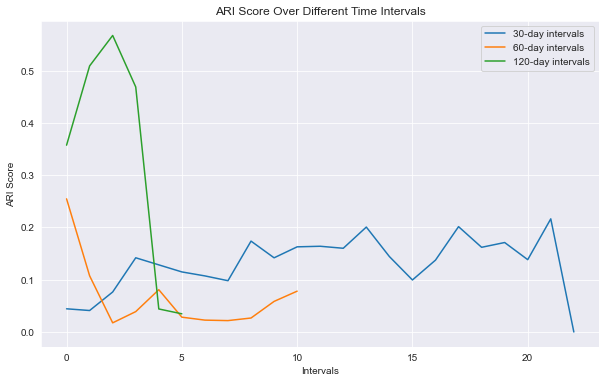

In [51]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from datetime import datetime

# Set environment variable to suppress the KMeans memory leak warning on Windows
os.environ["OMP_NUM_THREADS"] = "1"

# Load the data
db_path = os.path.join('..', 'data')
df_final_kmeans_path = os.path.join(db_path, 'df_final_kmeans_with_clusters.csv')
df_final_kmeans = pd.read_csv(df_final_kmeans_path)

# Define the date format
date_format = '%Y-%m-%d %H:%M:%S'  # Adjust this format according to your date format

# Identify the available date ranges
min_date_str = df_final_kmeans['order_purchase_timestamp'].min()
max_date_str = df_final_kmeans['order_purchase_timestamp'].max()
min_date = datetime.strptime(min_date_str, date_format)
max_date = datetime.strptime(max_date_str, date_format)

# Transform the 'order_purchase_timestamp' column to the number of days since the max date in the dataset
df_final_kmeans['days_since_last_purchase'] = df_final_kmeans['order_purchase_timestamp'].apply(lambda x: (max_date - datetime.strptime(x, date_format)).days)

# Display unique values of 'days_since_last_purchase'
print("days_since_last_purchase statistics:")
print(df_final_kmeans['days_since_last_purchase'].describe())

# Function to get the data for modeling
def get_data_for_model(data, start_time, interval):
    end_time = start_time + interval
    return data[(data['days_since_last_purchase'] >= start_time) & (data['days_since_last_purchase'] < end_time)]

# Define specific intervals
frequencies = [3, 7, 15, 30, 60, 120]  # 3, 7, 15, 30, 60, 120 days
scores_dict = {}

# Select only numeric columns for scaling and clustering
numeric_columns = df_final_kmeans.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('days_since_last_purchase')

# Initial model on the data of D_0
initial_time = df_final_kmeans['days_since_last_purchase'].min()

for interval in frequencies:
    scores = []
    D0 = get_data_for_model(df_final_kmeans, initial_time, interval)

    if not D0.empty and len(D0) >= 4:  # Ensure at least 4 samples
        scaler = StandardScaler()
        D0_scaled = scaler.fit_transform(D0[numeric_columns])
        model_0 = KMeans(n_clusters=4).fit(D0_scaled)  # Use 4 clusters

        # Temporal loop to track the stability of the model
        for t in range(int(initial_time) + interval, int(df_final_kmeans['days_since_last_purchase'].max()), interval):
            Di = get_data_for_model(df_final_kmeans, t, interval)
            if Di.empty or len(Di) < 4:  # Ensure at least 4 samples
                continue

            Di_scaled = scaler.transform(Di[numeric_columns])
            model_i = KMeans(n_clusters=4).fit(Di_scaled)  # Use 4 clusters

            # Calculate the ARI
            labels_0 = model_0.predict(Di_scaled)
            labels_i = model_i.predict(Di_scaled)
            score = adjusted_rand_score(labels_0, labels_i)
            scores.append(score)
    
    scores_dict[interval] = scores

# Print ARI scores for each interval
for interval, scores in scores_dict.items():
    print(f"Scores for interval {interval} days:\n", scores)

# Visualize the results
plt.figure(figsize=(10, 6))
for interval, scores in scores_dict.items():
    if scores:
        plt.plot(range(len(scores)), scores, label=f'{interval}-day intervals')
plt.xlabel('Intervals')
plt.ylabel('ARI Score')
plt.title('ARI Score Over Different Time Intervals')
plt.legend()
plt.show()


### Summary of ARI Scores and Stability

The ARI score is calculated for different time intervals (30, 60, 120 days) to evaluate the stability of the clusters over time.

- **30-Day Intervals**:
  - Scores: [0.044, 0.041, 0.076, 0.142, 0.128, 0.115, 0.107, 0.098, 0.174, 0.142, 0.163, 0.164, 0.160, 0.201, 0.144, 0.099, 0.137, 0.202, 0.162, 0.171, 0.138, 0.216, 0.0]
  - Interpretation: Moderate initial stability with fluctuations, decreasing over time.

- **60-Day Intervals**:
  - Scores: [0.255, 0.107, 0.017, 0.039, 0.081, 0.028, 0.023, 0.022, 0.027, 0.058, 0.078]
  - Interpretation: Higher initial stability with a steady decline over time.

- **120-Day Intervals**:
  - Scores: [0.357, 0.509, 0.567, 0.469, 0.044, 0.035]
  - Interpretation: High initial stability with a sharp decline in later intervals.

### Recommendations
- **Frequent Monitoring**: Monitor the clustering model every 30 days to detect early changes in cluster stability.
- **Model Re-evaluation**: Regularly re-evaluate and retrain the clustering model, especially after significant drops in ARI scores.
- **Investigate Anomalies**: Investigate periods with significant drops in ARI scores to understand and address the underlying causes.